# Feature Matching

Input files of this notebook:

- file...

Output files of this notebook:

- file...

## Why?

## How?

## What could it mean?

The feature matching takes it starting point in the reference data and attempts to identify corresponding features in the OSM data set.

Matching features in two road datasets with each their way of digitizing features and a potential one-to-many relationship between edges (for example in the case where one data set only maps road center lines, while the other map the geometries of each bike lane) is not a trivial task.

The method used here converts all network edges to smaller segments of a uniform length before looking for a potential match between the reference and the OSM data. The matching is done on the basis of the buffered distance between objects, the angle, and the undirected Hausdorff distance, and is based on the work of Koukoletsos et al. (2012) and Will (2014).

Based on the matching results we compute:
- The number and length of matched and unmatched edges, in total and per grid cell
- A comparison of the attributes of the matched edges (is their classification of cycling infrastructure as protected or unprotected the same?)

One the feature matching is complete, it is important to visually explore the results, since the success rate of the matching influences how the analysis of number of matches should be interpreted.

If the features in the two data sets have been digitized in very differnet ways - e.g. if one data set has digitised bike tracks as mostly straight lines, while the other includes more winding tracks, the matching will fail. This is also the case if they are placed too far from each other. If we visually can confirm that the same features do exist in both data sets, a lack of matches indicates that the geometries in the two data sets are too different. If we on the other hand can confirm that most real corresponding features have been identified, a lack of matches in an area indicates errors of commission or omission.

*The feature matching is faily computationally expensive and will take a while to compute. For the testing data provided in this repository (with around 8000 meters of OSM network the cell takes around 20 minutes to run).*

**Sections:**

1. Load and process data
2. Feature matching
    - Plot results: matched vs. unmatched features
3. Analyse results
    - Matched features by infrastructure type
    - Matche features per grid cell
4. Save results

_______________

## 1. Load and process data

In [1]:
import geopandas as gpd
import osmnx as ox
import yaml
import matplotlib.pyplot as plt
import contextily as cx
import json
import pickle
import os.path
from src import evaluation_functions as ef
from src import matching_functions as mf

### Load settings

In [2]:
with open(r'../config.yml') as file:

    parsed_yaml_file = yaml.load(file, Loader=yaml.FullLoader)

    study_area = parsed_yaml_file['study_area']
    study_area_poly_fp = parsed_yaml_file['study_area_poly']
    study_crs = parsed_yaml_file['study_crs']

    missing_tag_dict = parsed_yaml_file['missing_tag_analysis']

    incompatible_tags_dict = parsed_yaml_file['incompatible_tags_analysis']

    cycling_infrastructure_queries = parsed_yaml_file['cycling_infrastructure_queries']

    reference_geometries = parsed_yaml_file['reference_geometries']
    cycling_bidirectional = parsed_yaml_file['bidirectional']

    feature_matching = parsed_yaml_file['feature_matching']
    
print('Settings loaded!')

Settings loaded!


### Load OSM and reference graphs and grid

In [ ]:
# TODO: rename data variables

# Load simplified and non-simplified graphs
osm_graph = ox.load_graphml(
    f'../data/osm_{study_area}.graphml', 
    edge_dtypes={'cycling_bidirectional': ox.io._convert_bool_string})

osm_simplified_graph = ox.load_graphml(
    f'../data/osm_{study_area}_simple.graphml', 
    edge_dtypes={'cycling_bidirectional': ox.io._convert_bool_string, 
    'infrastructure_length':float})

ref_graph = ox.load_graphml(f'../data/ref_{study_area}.graphml')
ref_simplified_graph = ox.load_graphml(
    f'../data/ref_{study_area}_simple.graphml',
    edge_dtypes={'infrastructure_length':float})

print('Graphs loaded!')

# Load grid
grid = gpd.read_file(f'../data/grid_{study_area}.gpkg')
grid_ids = grid.grid_id.to_list()

with open(f'../data/osm_nodes_{study_area}.pickle', 'rb') as fp:
    osm_nodes = pickle.load(fp)

with open(f'../data/osm_edges_{study_area}.pickle', 'rb') as fp:
    osm_edges = pickle.load(fp)

with open(f'../data/osm_nodes_simplified_{study_area}.pickle', 'rb') as fp:
    osm_nodes_simplified = pickle.load(fp)

with open(f'../data/osm_edges_simplified_{study_area}.pickle', 'rb') as fp:
    osm_edges_simplified = pickle.load(fp)

# Joined data
with open(f'../data/osm_nodes_joined{study_area}.pickle', 'rb') as fp:
    osm_nodes_joined = pickle.load(fp)

with open(f'../data/osm_edges_joined{study_area}.pickle', 'rb') as fp:
    osm_edges_joined = pickle.load(fp)

with open(f'../data/osm_nodes_simplified_joined{study_area}.pickle', 'rb') as fp:
    osm_nodes_simp_joined = pickle.load(fp)

with open(f'../data/osm_edges_simplified_joined{study_area}.pickle', 'rb') as fp:
    osm_edges_simp_joined = pickle.load(fp)

print('OSM data loaded!')

with open(f'../data/ref_nodes_{study_area}.pickle', 'rb') as fp:
    ref_nodes = pickle.load(fp)

with open(f'../data/ref_edges_{study_area}.pickle', 'rb') as fp:
    ref_edges = pickle.load(fp)

with open(f'../data/ref_nodes_simplified_{study_area}.pickle', 'rb') as fp:
    ref_nodes_simplified = pickle.load(fp)

with open(f'../data/ref_edges_simplified_{study_area}.pickle', 'rb') as fp:
    ref_edges_simplified = pickle.load(fp)

# Joined data
with open(f'../data/ref_nodes_joined{study_area}.pickle', 'rb') as fp:
    ref_nodes_joined = pickle.load(fp)

with open(f'../data/ref_edges_joined{study_area}.pickle', 'rb') as fp:
    ref_edges_joined = pickle.load(fp)

with open(f'../data/ref_nodes_simplified_joined{study_area}.pickle', 'rb') as fp:
    ref_nodes_simp_joined = pickle.load(fp)

with open(f'../data/ref_edges_simplified_joined{study_area}.pickle', 'rb') as fp:
    ref_edges_simp_joined = pickle.load(fp)

print('Reference data loaded!')

__________________

## 2. Feature Matching

In [28]:
osm_segments = mf.create_segment_gdf(osm_simplified_edges, segment_length=10)
osm_segments.rename(columns={'osmid':'org_osmid'}, inplace=True)
osm_segments['osmid'] = osm_segments['edge_id'] # Because matching function assumes an id column names osmid as unique id for edges
osm_segments.set_crs(study_crs, inplace=True)
osm_segments.dropna(subset=['geometry'],inplace=True)

ref_segments = mf.create_segment_gdf(ref_simplified_edges, segment_length=10)
ref_segments.set_crs(study_crs, inplace=True)
ref_segments.rename(columns={'seg_id':'seg_id_ref'}, inplace=True) 
ref_segments.dropna(subset=['geometry'],inplace=True)

print('Segments created!')

matches_fp = f'../results/segment_matches_{study_area}.pickle'
if os.path.exists(matches_fp):
    print('Loading matches...')
    with open(matches_fp, 'rb') as fp:
        segment_matches = pickle.load(fp)

else:
    print('Starting feature matching...')
    
    buffer_matches = mf.overlay_buffer(reference_data=ref_segments, osm_data=osm_segments, ref_id_col='seg_id_ref', osm_id_col='seg_id', dist=15)

    print('Buffer matches found!')
    
    segment_matches = mf.find_matches_from_buffer(buffer_matches=buffer_matches, osm_edges=osm_segments, reference_data=ref_segments, angular_threshold=30, hausdorff_threshold=17)

    print('Feature matching completed!')

    with open(matches_fp, 'wb') as f:
            pickle.dump(segment_matches, f)

Segments created!
Loading matches...


### Plot feature matching results

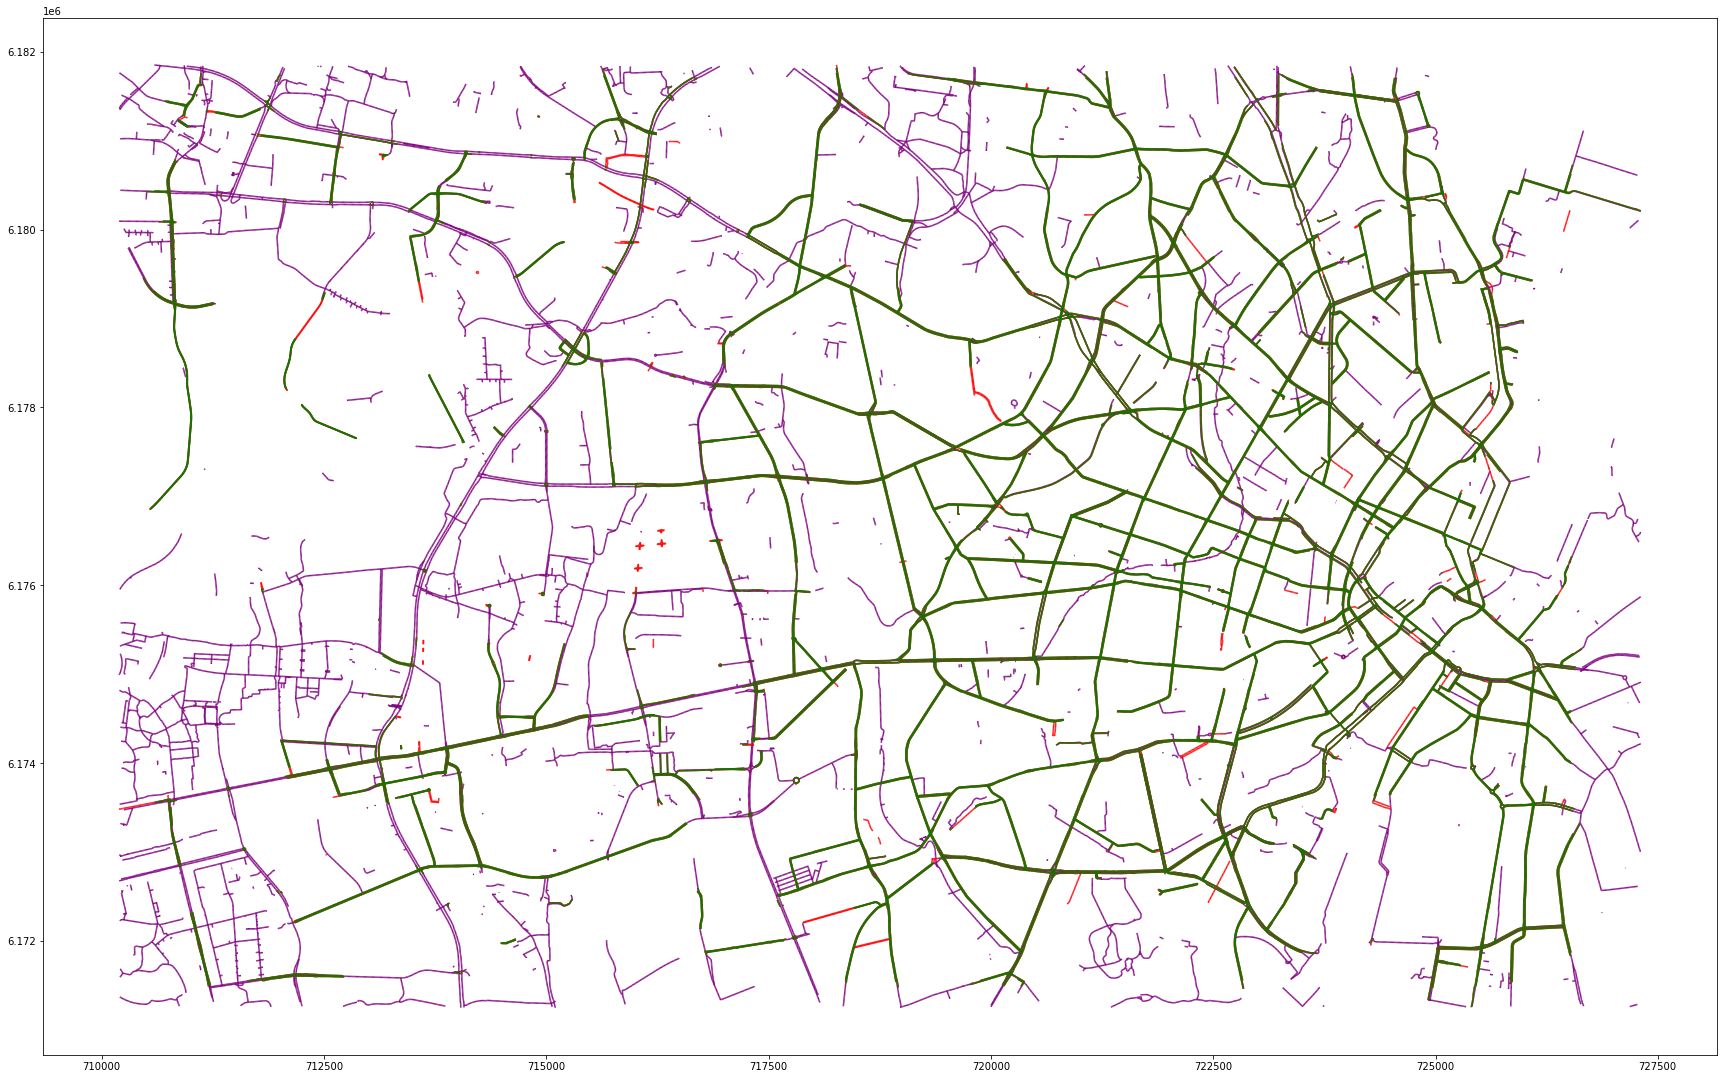

In [5]:
fig, ax = plt.subplots(figsize=(30,30))

osm_simplified_edges.plot(ax=ax, color='purple')
ref_simplified_edges.plot(ax=ax, color='red')
segment_matches.plot(ax=ax, color='green');

#TODO: folium plot, add legend

#### Matched features in the reference data

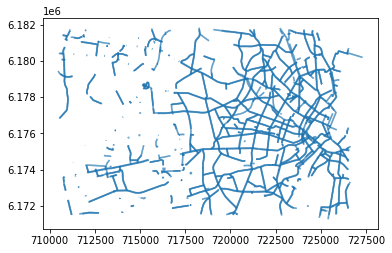

In [7]:
ref_matched_ids, ref_undec = mf.summarize_feature_matches(ref_segments, segment_matches, 'seg_id_ref','edge_id',osm=False)
ref_simplified_edges.loc[ref_simplified_edges.edge_id.isin(ref_matched_ids)].plot();

#### Matched features in the OSM data

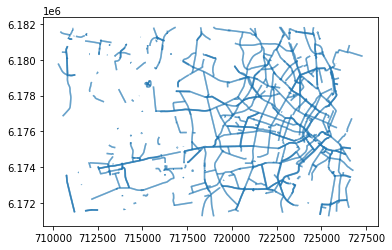

In [8]:
osm_matched_ids, osm_undec = mf.summarize_feature_matches(osm_segments, segment_matches,'seg_id','osmid',osm=True)
osm_simplified_edges.loc[osm_simplified_edges.edge_id.isin(osm_matched_ids)].plot();

#### Unmatched features in the OSM data

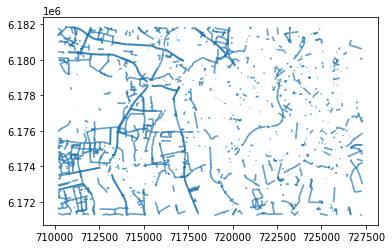

In [9]:
osm_simplified_edges.loc[~osm_simplified_edges.edge_id.isin(osm_matched_ids)].plot();

#### Unmatched features in the reference data

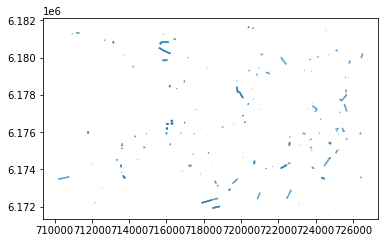

In [10]:
ref_simplified_edges.loc[~ref_simplified_edges.edge_id.isin(ref_matched_ids)].plot();

### Summarize results

In [11]:
count_matched_osm = len(osm_simplified_edges.loc[osm_simplified_edges.edge_id.isin(osm_matched_ids)])
count_matched_ref = len(ref_simplified_edges.loc[ref_simplified_edges.edge_id.isin(ref_matched_ids)])

print(f'Out of {len(osm_simplified_edges)} OSM edges, {count_matched_osm} were matched with a reference edge.')
print(f'Out of {len(ref_simplified_edges)} reference edges, {count_matched_ref} were matched with an OSM edge.')

length_matched_osm = osm_simplified_edges.loc[osm_simplified_edges.edge_id.isin(osm_matched_ids)].geometry.length.sum()
length_unmatched_osm = osm_simplified_edges.loc[~osm_simplified_edges.edge_id.isin(osm_matched_ids)].geometry.length.sum()

length_matched_ref = ref_simplified_edges.loc[ref_simplified_edges.edge_id.isin(ref_matched_ids)].geometry.length.sum()
length_unmatched_ref = ref_simplified_edges.loc[~ref_simplified_edges.edge_id.isin(ref_matched_ids)].geometry.length.sum()

print(f'Out of {osm_simplified_edges.geometry.length.sum()/1000:.2f} km of OSM edges, {length_matched_osm/1000:.2f} km were matched with a reference edge.')
print(f'Out of {ref_simplified_edges.geometry.length.sum()/1000:.2f} km of reference edges, {length_matched_ref/1000:.2f} km were matched with an OSM edge.')

results_feature_matching = {
    'osm_matched_count': count_matched_osm,
    'ref_matched_count': count_matched_ref,
    'osm_matched_length': length_matched_osm,
    'ref_matched_length': length_matched_ref
}

Out of 5479 OSM edges, 2474 were matched with a reference edge.
Out of 4208 reference edges, 3918 were matched with an OSM edge.
Out of 807.59 km of OSM edges, 420.61 km were matched with a reference edge.
Out of 623.52 km of reference edges, 600.67 km were matched with an OSM edge.


________________

## 3. Analyse feature matching results

### Compare infrastructure type in matched features

In [37]:
updated_osm = mf.update_osm(osm_segments, osm_simplified_edges, segment_matches, 'protected', 'edge_id','seg_id')

#### Plotting edges marked as *protected* infrastructure in both datasets

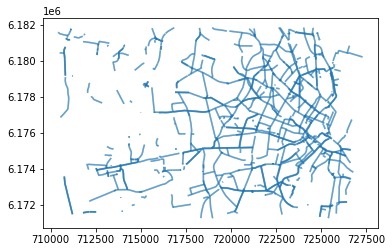

In [38]:
updated_osm.loc[updated_osm.protected == updated_osm.protected_matched].plot();

#### Plotting edges with differing classifications

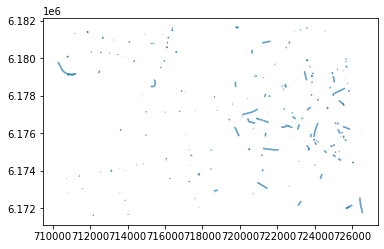

In [39]:
updated_osm.loc[updated_osm.protected != updated_osm.protected_matched].plot();

#### Count and measure length of matched and unmatched features per grid cell

In [40]:
osm_matched = osm_edges_s_j.loc[osm_edges_s_j.edge_id.isin(osm_matched_ids)]

osm_unmatched = osm_edges_s_j.loc[~osm_edges_s_j.edge_id.isin(osm_matched_ids)]

# Count features in each grid cell
all_data_osm = [osm_matched, osm_unmatched]
labels_osm = ['osm_matched','osm_unmatched']

for data, label in zip(all_data_osm, labels_osm):

    df = ef.count_features_in_grid(data,label)

    grid = grid.merge(df, on='grid_id', how='left')

    df = ef.length_of_features_in_grid(data,label)

    grid = grid.merge(df, on='grid_id', how='left')
    

ref_matched = ref_edges_s_j.loc[ref_edges_s_j.edge_id.isin(ref_matched_ids)]
ref_unmatched = ref_edges_s_j.loc[~ref_edges_s_j.edge_id.isin(ref_matched_ids)]

# Count features in each grid cell
all_data_ref = [ref_matched, ref_unmatched]
labels_ref = ['ref_matched','ref_unmatched']

for data, label in zip(all_data_ref, labels_ref):

    df = ef.count_features_in_grid(data,label)

    grid = grid.merge(df, on='grid_id', how='left')

    df = ef.length_of_features_in_grid(data,label)

    grid = grid.merge(df, on='grid_id', how='left')

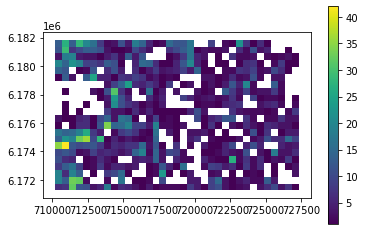

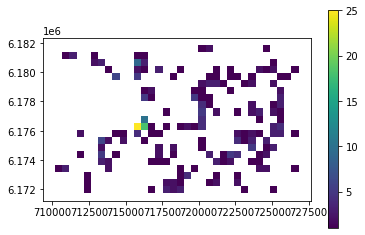

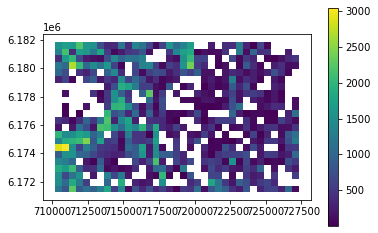

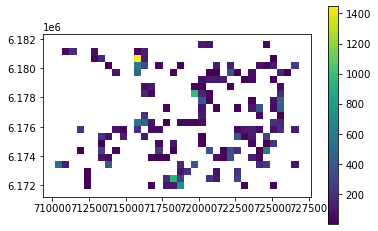

In [41]:
# TODO: Fix plots
grid.plot(column='count_osm_unmatched', legend=True);
grid.plot(column='count_ref_unmatched', legend=True);

grid.plot(column='length_osm_unmatched', legend=True);
grid.plot(column='length_ref_unmatched', legend=True);

____________________

## 4. Save results

In [42]:
with open(f'../results/feature_matches_{study_area}.json', 'w') as outfile:
    json.dump(results_feature_matching, outfile)

with open(f'../results/grid_results_feature_matching_{study_area}.pickle', 'wb') as f:
    pickle.dump(grid, f)